<a href="https://colab.research.google.com/github/lahmidiamoumen/well-prediction/blob/master/auto_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install git+https://github.com/tensorflow/docs
#!pip install plotly==4.6.0

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import regularizers
from keras import backend as K
from tensorflow.keras import layers

print(tf.__version__)

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kjqnkqi3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-kjqnkqi3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=83101 sha256=af809879d065c6fd1dc957264e2bac124617cb16073f7d924b62b11b20f450bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-lfnwj30n/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.2.0-rc2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Well Dataset

In [0]:
dataset = pd.read_csv('drive/My Drive/data_all.csv')
dataset = dataset[:7516]       #well_1
#dataset = dataset[7517:13163]  #well_2 from 2-> 8120
#dataset = dataset[13164:]      #well_3
#dataset = dataset[:13163]  #well_1&2 from
#ignore = dataset[(dataset.ROP_time > 60) & ((dataset.For == 1) | (dataset.For == 2)) ]
#dataset = dataset.drop(ignore.index)
#dataset = dataset[dataset.For > 3]

In [7]:
log = [dataset.ROP_time, dataset.Torque_Avg,  dataset.WOB_Avg,
       dataset.Flow_In_Pumps_Avg, dataset.RPM_Avg, dataset.SPP_Avg]

labels = ['ROP', 'TOURQUE', 'FLOW', 'WOB', 'RPM', 'SPP']

colors = ['#AB63FA', 'green', '#851e52', '#f79b32',
            'red', '#636EFA', 'black']

fig = make_subplots( cols=6)
for i in range(0, 6):
        fig.add_trace(go.Scatter(x=log[i], y=dataset.DEPTH, mode='lines',
                                    name=labels[i],
                                    line=dict(color=colors[i], width=1)),
                                     row=1, col=i + 1)
        fig.update_xaxes(title_text=labels[i], col= i+1)
        fig.update_yaxes(autorange='reversed', col=i+1)

        
fig.update_xaxes(title_text=labels[0], range=[-10, 130], col= 1)
fig.update_xaxes(title_text=labels[2], range=[-3, 27], col= 3)

fnt = dict(
        family='Helvetica',
        size=12,
        color='rgb(200, 200, 200)')

fig.update_layout(
    xaxis=dict(
        title='ROP',
        tickfont=fnt,
    ),
    yaxis=dict(
        autorange='reversed',
        title='Depth',
        tickfont=fnt,
    ),
    width=1200,
    height=700,
    font=fnt,
    hovermode="closest",
    legend=dict(y=0.5, traceorder='reversed', font_size=16),
    template="plotly_dark"
)

fig.show()

In [8]:
for i in range(1,12):
    print(i," => ",dataset[dataset.For == i].shape)
dataset.describe()

1  =>  (826, 13)
2  =>  (497, 13)
3  =>  (318, 13)
4  =>  (438, 13)
5  =>  (667, 13)
6  =>  (301, 13)
7  =>  (502, 13)
8  =>  (691, 13)
9  =>  (1342, 13)
10  =>  (462, 13)
11  =>  (984, 13)


,For,DEPTH,Bit_Position,WOB_Max,WOB_Avg,WOB_Min,Torque_Max,Torque_Avg,Torque_Min,SPP_Avg,RPM_Avg,Flow_In_Pumps_Avg,ROP_time
count,7516.000000,7516.000000,7516.000000,7516.000000,7516.000000,7516.0,7516.000000,7516.000000,7516.000000,7516.000000,7516.000000,7516.000000,7516.000000
mean,6.930149,1663.342889,1663.342807,13.439596,10.359163,0.0,14589.740953,10031.380857,4330.322512,2302.008638,147.967704,2916.287700,15.458063
std,3.504286,623.674128,623.674139,4.323381,4.640667,0.0,2439.208058,2654.020795,2830.218047,314.992428,26.188667,180.419677,13.662627
min,1.000000,518.140000,518.140000,0.000000,0.000000,0.0,1030.000000,728.080000,0.000000,1547.920000,16.250000,1471.330000,0.600000
25%,4.000000,1056.632500,1056.632500,10.000000,6.830000,0.0,13694.500000,8692.955000,2261.250000,2166.397500,132.580000,2931.670000,6.000000
50%,8.000000,1805.245000,1805.245000,14.000000,10.170000,0.0,14793.500000,10198.500000,4300.000000,2432.330000,150.500000,2967.250000,10.800000
75%,10.000000,2236.787500,2236.787500,17.000000,14.020000,0.0,16012.000000,11743.560000,6084.250000,2489.440000,169.580000,3010.330000,21.000000
max,12.000000,2464.120000,2464.120000,29.000000,21.670000,0.0,19811.000000,17865.000000,15078.000000,2797.580000,188.170000,5348.500000,111.600000


In [9]:
px.line(dataset, x="DEPTH", y="ROP_time",width=1300, render_mode="webgl", template="plotly_dark").show()

## the impact of RPM over ROP

In [10]:

df = px.data.tips()
fig = px.scatter(dataset, x="DEPTH", y="ROP_time", color="RPM_Avg",width=1300, 
           color_continuous_scale=px.colors.sequential.Viridis, render_mode="webgl", template="plotly_dark")
fig.show()

# Machine learning model
`adam` optimizer wish have a better performance is used to calculate the gradient decet. 

`l2 regularizer` to add some noise to the model in order to reduce the overfitting.

`activativaion functions` for regression relu / elu / selu / leakyRleu.

`initialization` of weight and biases there are several algorithms such as he_normal...

`epoch`  we'll use an *EarlyStopping callback* that tests a training condition for  every epoch. automatically stop training when the validation score doesn't improve.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

## Normalize the data
mean and standard deviation defined as folow



<img src="img/norma.png" />

`[a,b]` interval so we chose `[-1,1]`

In [0]:
def norm(x,d):
    #return 2*(x-d['min'])/(d['max']-d['min']) -1
    return (x - d['mean']) / d['std']

In [0]:

columns = [ 'For', 'DEPTH', 'Bit_Position', 'WOB_Max', 'WOB_Avg', 'WOB_Min',
            'Torque_Max', 'Torque_Avg', 'Torque_Min', 'SPP_Avg', 'RPM_Avg',
            'Flow_In_Pumps_Avg', 'ROP_time']

to_remove = ['For', 'WOB_Min', 'Bit_Position']
rop = "ROP_time"
validation = 0.2
training = 0.8
history = None
annotations = [dict(xref='paper', yref='paper', x=0.0, y=1.05,
                        xanchor='left', yanchor='bottom',
                        text='ROP prediction',
                        font=dict(family='Arial',
                                  size=30,
                                  color='rgb(210,210,210)'),
                        showarrow=False)]

def graph(test_rop, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_rop, test_predictions, color='blue')
    plt.xlabel('True Values [ROP]')
    plt.ylabel('Predictions [ROP]')
    lims = [-10, 120]
    plt.xlim(lims)
    plt.ylim(lims)
    return plt.plot(lims, lims ,color='red', linewidth=2, label = 'Linear regression\n')

def get_valide(df):
  return df[(df < 3  ).all(1) & (df > -3  ).all(1)]

def get_optimizer(N_TRAIN):
    BATCH_SIZE = 1879
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=0.1,
    staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

def build_model(lenth,hidden,layer,data_len):
    #init = keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None)
    activation = tf.keras.layers.LeakyReLU() #'elu' 
    optimizer = get_optimizer(data_len)
    #optimizer = tf.keras.optimizers.RMSprop(0.05)
    #optimizer = tf.keras.optimizers.Adam(0.002)
    #optimizer = tfa.optimizers.AdamW(0.001)
    model = None
    regularizer = regularizers.l2(0.01)
    #init = tf.keras.initializers.GlorotNormal()
    init = 'he_normal' 
    activation = 'tanh'

    sequence = [layers.Dense(hidden,
                             activation= activation,
                             kernel_initializer=init, 
                             kernel_regularizer=regularizer,
                             input_shape=(lenth,)
                             ),
                layers.BatchNormalization()]

    for _ in range(layer):
        sequence.append(layers.Dense(hidden,
                                     activation= activation,
                                     kernel_initializer=init, 
                                     kernel_regularizer=regularizer))
        sequence.append(layers.BatchNormalization())
     
    sequence.append(layers.Dense(1))

    model = keras.Sequential(sequence)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae', 'mse'])
    return model

def ml(i,hidden=18,layer=1):
    ds = dataset#[dataset.For != 4]
    target = list( set(dataset.columns) - set(to_remove))
    ds = ds[target]

    train_dataset = ds.sample(frac=training,random_state=0) # shufled  
    test_dataset = ds.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop('ROP_time')
    train_stats = train_stats.transpose()

    train_rop = train_dataset.pop(rop)
    test_rop = test_dataset.pop(rop)

    
    normed_train_data = norm(train_dataset,train_stats)
    normed_test_data = norm(test_dataset,train_stats)

    model = build_model(len(train_dataset.keys()),hidden,layer,len(normed_train_data))

    EPOCHS = 1000
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(normed_train_data, train_rop, 
                        epochs=EPOCHS, validation_split = validation, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
    
    test_predictions = model.predict(normed_test_data).flatten()

    from sklearn.metrics import r2_score
    print("\n",i,"accuracy: %.2f%%" % (r2_score(test_rop, test_predictions)*100))
    
    return test_rop,test_predictions,test_dataset.DEPTH,history

### Train the model

In [38]:
rop_ = []
pred_ = []
depth_ = []
parameter = {
                1: [19,2],
                2: [42,3],
                3: [28,3],
                4: [18,2],
                5: [27,2],
                6: [19,3],
                7: [32,3],
                8: [5,2],
            }
#parameter.get(i)[0] /27.3
history
for i in range(1):
    ro,pr,dep,history = ml(i,26,1)
    rop_ = np.concatenate((rop_,ro))
    pred_ = np.concatenate((pred_,pr))
    depth_ = np.concatenate((depth_,dep))


Epoch: 0, loss:163.4353,  mae:8.8595,  mse:162.5735,  val_loss:86.2443,  val_mae:6.0311,  val_mse:84.8520,  
..................................
 0 accuracy: 71.39%


In [39]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter( y=depth_,x=rop_,
                    mode='lines',
                    name='true ROP'))
fig.add_trace(go.Scatter(x=pred_, y=depth_,
                    mode='lines',
                    name='predicted'))
# Title
fig.update_layout(
    annotations=annotations,
    xaxis=dict(title='ROP'),
    yaxis=dict(
        autorange='reversed',
        title='Depth',
    ),
    width=400,
    height=850,
    font=fnt,
    legend=dict(y=0.5, traceorder='reversed', font_size=16),
    template="plotly_dark"
)
fig.show()

# History Graph 
is used to trace the overfitting and underfitting

the metric we used is MSE

the mean squared error (MSE) is the average squared difference between the estimated values and the actual value

<img src="img/mse.jpg" />

Text(0, 0.5, 'MSE')

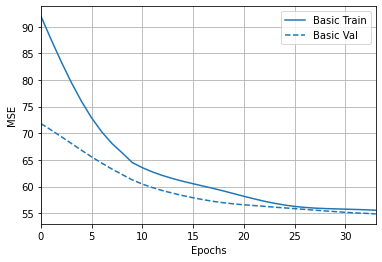

In [40]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = 'mse')    
plt.ylabel('MSE')

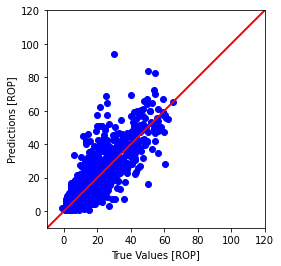

In [41]:
graph(pred_, rop_)

# gaussian

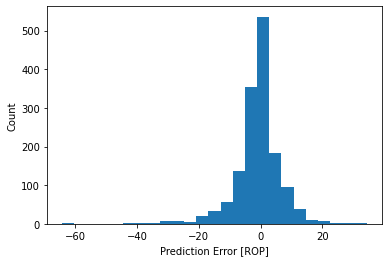

In [42]:
error = pred_ - rop_
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [ROP]")
_ = plt.ylabel("Count")

# accuracy: 77.69%